In [1]:
# Загрузим .mat файл в Python 
from scipy.io import loadmat # библиотека для загрузки файла в формате MATLAB .mat
data = loadmat('ex4data1.mat')
# и посмотрим его структуру
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [2]:
# как видно данные уже разделены на "X" и "y". Давайте присвоим переменные "X" and "y" для наших двух массивов
# и посмотрим их размерность.
X = data['X']
y = data['y']

X.shape, y.shape

((5000, 400), (5000, 1))

Представлено 5,000 обучающих примеров в градациях серого цвета размером 20 на 20 пикселей. Каждый пиксель представлен числом с плавающей запятой, указывающим интенсивность оттенков серого в этом месте. Сетка пикселей размером 20 на 20 “преобразована" в 400-мерный вектор. Это дает нам матрицу X размером 5000 на 400, где каждая строка является обучающим примером для рукописного цифрового изображения.

In [ ]:
# Давайте посмотрим на структуру любой строки в массиве 'X', например строки 2999 
X[2999]

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

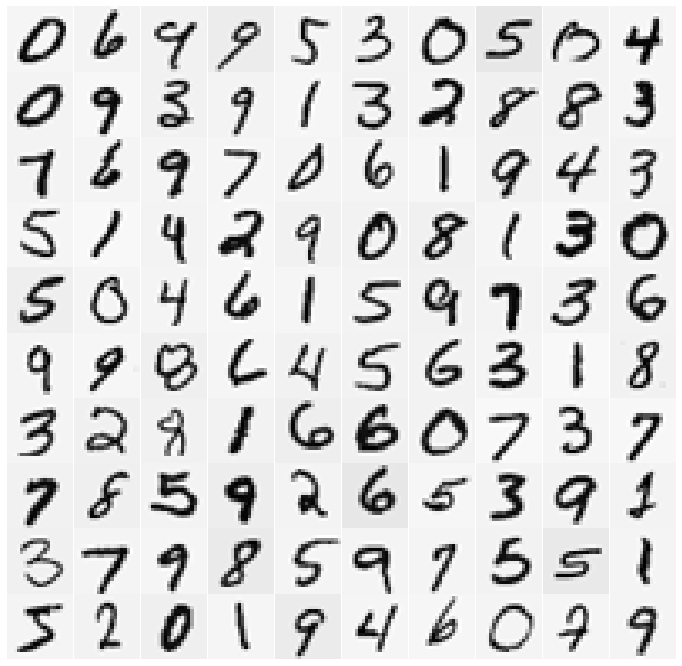

In [5]:
def displayData():
    """
    Выбераем случайным образом 100 строк из X с помощью np.random.choice(),
    строим 100 картинок, каждую размером 20x20 пикселей,
    которые преобразуются предварительно из строки в 400 значений оттенков серового,
    и сибираем все 100 картинок в одной.
    """
    # Нарисуем 100 картинок расположив их в виде 10*10 и удалим gaps
    # посредством gridspec.
    fig, axarr = plt.subplots(10, 10,
                             figsize=(12, 12),
                             gridspec_kw={'wspace':0,
                                          'hspace':0})
    for i in range(10):
        for j in range(10):
            # len(X)=5,000; выберим случайную строку.
            idx = np.random.choice(len(X), 1)
            # Index the array X with the indices.
            pixels = X[idx] # shape(1, 400). Данные произвольной строки мы смотрели ранее
            pixels = pixels.reshape(-1, 20) # преобразуем строку в матрицу 400=20*20, те. shape(20, 20)
            axarr[i,j].imshow(pixels.T, cmap='gray_r') # "matplotlib.pyplot.imshow()" - Display an image, i.e. data on a 2D regular raster.
            # Remove ticks.
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            # Turn off axes.
            axarr[i,j].axis('off')
    plt.show()

displayData()

## Vectorizing Regularized Logistic Regression

In [6]:
# Сигмод-функция
def sigmoid(z):
    sigmoid = 1 / (1 + np.exp(-z))
    return sigmoid

def computeCost(theta, X, y, lambda_coef):
    """
    Compute the cost function.
    Args:
        theta: array shape(n+1, 1) 
        X: array shape(m, n+1) 
        y: array shape(m, 1)
        lambda_coef: int
    Returns:
        cost: float
    """
    m = X.shape[0]
    # Do matrix multiplication with numpy.dot
    h_theta = sigmoid(np.dot(X, theta))
    term1 = np.dot(-y.T, np.log(h_theta))
    term2 = np.dot((1 - y).T, np.log(1 - h_theta))
    # Exclude theta_0!!!
    reg_term = (lambda_coef / (2 * m)) * np.sum(np.square(theta[1:]))
    cost = (np.sum(term1 - term2) / m) + reg_term
    return cost

def computeGradient(theta, X, y, lambda_coef):
    """
    Compute the gradient.
    Args:
        theta: array shape(n+1, 1) 
        X: array shape(m, n+1) 
        y: array shape(m, 1)
        lambda_coef: int
    Returns:
        gradient: array shape(n+1, m)
    """
    m = X.shape[0]
    h_theta = sigmoid(np.dot(X, theta))
    # Exclude theta_0!!!
    reg_term = (lambda_coef / m) * (theta[1:])
    gradient = (1 / m) * np.dot(X.T, (h_theta - y))
    gradient[1:] = gradient[1:] + reg_term
    return gradient

## One-vs-all Classification

In [7]:
from scipy.optimize import minimize

def oneVsAll(X, y, K, lambda_coef):
    """
    Train K logisitc regression classifiers 
    and returns each of these classifiers
    in an array Thetas, where the i-th row
    corresponds to the classifier for label i.
    Args:
        X: array shape(m, n) 
        y: array shape(m, 1)
        K: int
        lambda_coef: int
    Returns:
        Thetas: array shape(K, n+1)
    """    
    # Get the number of training examples, m.
    m = X.shape[0]
    # Get the number of features, n.
    n = X.shape[1]

    # Create an array of shape(K, n+1) for each K class,
    # i.e. for each digit 0 to 9.
    Thetas = np.zeros((K, n+1))
    
    #Insert a 1's column to X.
    X = np.insert(X, 0, 1, axis=1)

    # Train each classifier independently from 1 to K.
    for i in range(0, K):
        print("Training the classifier for class k = {}...".format(i))
        # Take into account that class "10" corresponds to "0".
        if i == 0:
            x = 10
        else:
            x = i
        # Initialize theta.
        theta = np.zeros((n+1, 1))
        y_i = np.array([1 if class_k == x else 0 for class_k in y])
        y_i = np.reshape(y_i, (m, ))

        # Minimize the cost function.
        # Various methods were tested. It was found that 'TNC'
        # is faster and gives very good results.
        res = minimize(fun=computeCost, x0=theta, args=(X, y_i, lambda_coef),
                       method='TNC', jac=computeGradient)
        Thetas[i, :] = res.x
    print("Training is completed!")
    return Thetas

In [8]:
import warnings
warnings.filterwarnings('ignore')

Thetas = oneVsAll(X, y, 10, 0)

Training the classifier for class k = 0...
Training the classifier for class k = 1...
Training the classifier for class k = 2...
Training the classifier for class k = 3...
Training the classifier for class k = 4...
Training the classifier for class k = 5...
Training the classifier for class k = 6...
Training the classifier for class k = 7...
Training the classifier for class k = 8...
Training the classifier for class k = 9...
Training is completed!


## One-vs-all Prediction

In [9]:
# Create a prediction function.
def predictOneVsAll(X, theta):
    """
    Predict whether the label is 0 or 1 using the
    learned logistic regression parameters Thetas.
    Probability "p" computes the predictions for X
    using a threshold at 0.5 i.e., if
    sigmoid(np.dot(X, theta.T)) >= 0.5, predict 1.
    "p" is set to a vector of predictions (from 1 to K).
    The numpy.argmax function returns the index of the
    max element.
    Args:
        X: array shape(m, n)
        theta: array shape(K, n+1), the optimal parameters
    Returns:
        p_argmax: list of "m" max p values
    """
    #Insert a 1's column to X.
    X = np.insert(X, 0, 1, axis=1) # shape(5000, 401)
    p = sigmoid(np.dot(X, theta.T)) # shape(5000, 10)
    p_argmax = np.argmax(p, axis=1) # shape(5000,)
    # Replace 0's with 10's to fix that a “0” digit is labeled as “10”.
    p_argmax = [10 if x == 0 else x for x in p_argmax]
    return p_argmax

predicted = predictOneVsAll(X, Thetas)
correct = np.sum(predicted == y.reshape(-1))
total = len(predicted)
print('Accuracy score: {}%'.format(100 * correct / total))


Accuracy score: 97.34%


## Нейронная сеть. Прогноз на основе загруженных коэффициентов ex3weights.mat.

In [10]:
weights = loadmat('ex3weights.mat')

Theta1 = weights['Theta1']
Theta2 = weights['Theta2']

print("Shape of Theta1: ", Theta1.shape)
print("Shape of Theta2: ", Theta2.shape)

# Create a prediction function.
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network.
    Probability "p" outputs the predicted label of X given the
    trained weights of a neural network (Theta1, Theta2).
    "u" is the units in the second layer.
    Args:
        Theta1: array shape(u, n+1)
        Theta2: array shape(K, u+1)
        X: array shape(m, n)
    Returns:
        p_argmax: list of "m" max p values
    """
    #Insert a 1's column to X.
    X = np.insert(X, 0, 1, axis=1) # shape(5000, 401)
    a2 = sigmoid(np.dot(X, Theta1.T)) # shape(5000, 25)
    #Insert a 1's column to a2.
    a2 = np.insert(a2, 0, 1, axis=1) # shape(5000, 26)
    p = sigmoid(np.dot(a2, Theta2.T)) # shape(5000, 10)
    p_argmax = np.argmax(p, axis=1) # shape(5000,)
    # Add 1 to fix for zero indexed array.
    p_argmax = p_argmax + 1
    # Replace 0's with 10's to fix that a “0” digit is labeled as “10”.
    p_argmax = [10 if x == 0 else x for x in p_argmax]
    return p_argmax

predicted = predict(Theta1, Theta2, X)
correct = np.sum(predicted == y.reshape(-1))
total = len(predicted)
print('\nAccuracy score: {}%'.format(100 * correct / total))

Shape of Theta1:  (25, 401)
Shape of Theta2:  (10, 26)

Accuracy score: 97.52%
